In [23]:
# https://www.sktime.net/en/v0.24.1/examples/transformation/rocket.html
from sktime.datatypes import check_raise, convert_to
from sktime.transformations.panel.rocket import Rocket, MiniRocket, MiniRocketMultivariate, MultiRocketMultivariate
from matplotlib import pyplot as plt
from sktime.utils.plotting import plot_series
from sklearn.linear_model import RidgeClassifierCV, RidgeCV, SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import ipywidgets as widgets
import numpy as np
import glob
import pandas as pd
import os
from sktime.pipeline import make_pipeline

In [24]:
def load_individual_instance(filename, needed_columns):
    df = pd.read_csv(filename)
    for col in needed_columns:
         if not (col in df.columns):
            df[col] = 0.0
    # Ensure all the columns are in the correct order!
    return df[needed_columns]    

In [25]:
def count_proportion_multivariate(df, num_columns):
    # Counts all the non zero values across multiple columns
    sum_set = sum(df.aggregate(func=np.count_nonzero, axis='columns'))
    return sum_set / (len(df) * num_columns)

In [26]:
def create_combined_data(base_dir, filenames, needed_columns):
    combined_data_m = map(lambda file: load_individual_instance(base_dir + "/" + file, needed_columns), filenames)
    combined_data = list(combined_data_m)
    print("Check data: ",check_raise(combined_data, mtype="df-list"))
    return combined_data

In [27]:
def find_data_in_dir(csv_directory_train, csv_directory_test, train_split_num):
    files_train = os.listdir(csv_directory_train)
    files_test = os.listdir(csv_directory_test)
    return files_train, files_test

In [28]:
def single_metric_value(m, divisor):
    f = np.floor(m/divisor)
    if (f < 0):
        return 0.0
    else:
        return f

In [29]:
def metrics_map_to_class(metrics, divisor):
      return np.array([single_metric_value(v,divisor) for v in metrics])

In [37]:
def read_data(results_directory, mfile):
    data_files = list(map(os.path.basename, sorted(glob.glob(results_directory + "/Test*"))))
    metrics = pd.read_csv(mfile)
    return data_files, metrics

In [38]:
#def filter_metrics(metrics, files_train, files_test):
#    print(metrics)
#    metrics_train = metrics["testName"].isin(files_train)
#    #metrics_test = metrics["testName"].isin(files_test)
    

In [39]:
def split_data_first_num(data_files, metrics, split_num, metric_col_name):
    data_files_train = data_files[:split_num]
    data_files_test = data_files[split_num:]
    # Corresponding split of the metrics - factor this out
    metrics_train = metrics[metrics["testName"].isin(data_files_train)][metric_col_name]
    metrics_test = metrics[metrics["testName"].isin(data_files_test)][metric_col_name]
    return data_files_train, data_files_test, metrics_train, metrics_test

In [40]:
def split_data_periodic_split(data_files, metrics, nth_split, metric_col_name):
    data_files_train = [y for x,y in enumerate(data_files) if x%(nth_split) != (nth_split-1)]
    data_files_test = [y for x,y in enumerate(data_files) if x%(nth_split) == (nth_split-1)]
    # Corresponding split of the metrics - factor this out
    metrics_train = metrics[metrics["testName"].isin(data_files_train)][metric_col_name]
    metrics_test = metrics[metrics["testName"].isin(data_files_test)][metric_col_name]
    return data_files_train, data_files_test, metrics_train, metrics_test

In [41]:
def rocket_regression(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name, num_kernels):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])

    print(metrics_train)
    
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))
    
    rocket_pipeline = make_pipeline(MultiRocketMultivariate(num_kernels=num_kernels, n_jobs=-1), StandardScaler(with_mean=False), RidgeCV(alphas=(0.1, 1.0, 10.0))) 
    rocket_pipeline.fit(train_data, metrics_train)
    print("ROCKET fit done!")
    score = rocket_pipeline.score(test_data, metrics_test)
    
    print("Score on test data = ",score)
    print("ROCKET score done!")

    predicted_val = rocket_pipeline.predict(test_data)
    actual_val = metrics_test
    predicted_vs_actual = pd.DataFrame({'predicted_val':predicted_val, 'actual_val':actual_val}, columns = ['predicted_val', 'actual_val'])
    return [rocket_pipeline, predicted_vs_actual]

In [35]:
def metricval_to_class(metric_vals, metric_max, metric_min, bin_count):
    bins = np.linspace(metric_min, metric_max, bin_count)
    digitized = np.digitize(metric_vals, bins)
    return digitized

In [59]:
def rocket_classifier(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name, num_kernels, class_count):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])

    print(metrics_train)
    
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))
    
    metric_max = np.max([np.max(metrics_train), np.max(metrics_test)])
    metric_min = np.min([np.min(metrics_train), np.min(metrics_test)])
    print(metric_max)
    print(metric_min)
    train_class = metricval_to_class(metrics_train, metric_max, metric_min, class_count)
    test_class = metricval_to_class(metrics_test, metric_max, metric_min, class_count)
    print(train_class)
    print(test_class)
    
    print("Check data format train_metrics: ", check_raise(train_class, mtype="np.ndarray"))
    print("Check data format test_metrics: ", check_raise(test_class, mtype="np.ndarray"))
    
    rocket_pipeline_classifier = make_pipeline(MultiRocketMultivariate(num_kernels=num_kernels, n_jobs=-1), StandardScaler(with_mean=False), RidgeClassifierCV(alphas = np.logspace(-3, 3, 10)))
    rocket_pipeline_classifier.fit(train_data, train_class)
    print("ROCKET classifier fit done!")
    score = rocket_pipeline_classifier.score(test_data, test_class)
    print("Score on test data = ",score)
    print("ROCKET classifier score done!")
    predicted_class = rocket_pipeline_classifier.predict(test_data)
    actual_class = test_class
    predicted_vs_actual = pd.DataFrame({'predicted_class':predicted_class, 'actual_class':actual_class}, columns = ['predicted_class', 'actual_class'])
    return [rocket_pipeline_classifier, predicted_vs_actual]

In [80]:
base_dir = "./temp-data-512-turtlebot-twooperations-var/"
metric_name = "distanceToPoint3D"

needed_columns = ['distortVelocity_variable', "reverseVehicle_variable"]
mfile = base_dir + "metrics.csv"
num_kernels = 10000

In [88]:
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)
rocket_reg, predicted_vs_actual = rocket_regression(base_dir, data_files_train, data_files_test, metrics_train, metrics_test, metric_name, num_kernels)
predicted_vs_actual

Check data:  True
Check data:  True
[0.15749082 0.14346933 1.00408208 2.94381553 0.22806215 0.22831414
 3.01421561 0.23358618 0.22935933 0.22436281 0.24038063 0.25102104
 0.80679933 1.97319664 0.23412839 0.22864355 1.47171317 2.11847535
 0.62415539 0.23595502 0.24154673 0.2363405  0.22993449 0.23239383
 0.0388223  0.23769173 0.61596852 0.23249489 0.02697153 0.96534803
 0.04365061 0.21855372 0.45748453 0.68027561 2.32492612 0.21857284
 0.23580512 0.23242813 1.3372899  0.24113374 0.23144615 0.22646731
 1.55308745 0.23469847 0.22344082 1.02125594 0.10789458 0.25598327
 3.62131189 1.36568888 0.97842165 0.2262487  0.24037121 1.41492459
 0.23039936 0.24026694 0.23807834 0.22387306 0.22802279 3.55675216
 0.22313273 0.06267908 0.77730665 0.21157251 0.78682945 2.89962941
 1.46383579 0.14448205 0.20712126 0.24154987 1.3634341  0.15849206
 0.24205773 0.23675239 2.51881009 0.2249537  0.27820776 3.19262959
 0.24088036 1.35636317 1.84758466 0.13332511 0.26376725 2.8335511
 0.11000688 3.19387155 0.22

,predicted_val,actual_val
0,0.396376,0.175767
1,0.544245,0.874203
2,0.476912,0.132981
3,-0.319726,0.027250
4,0.602481,0.562118
5,0.226632,0.236285
6,0.026792,0.236751
7,0.238088,0.238125
8,0.078284,0.271880
9,2.318943,1.048451


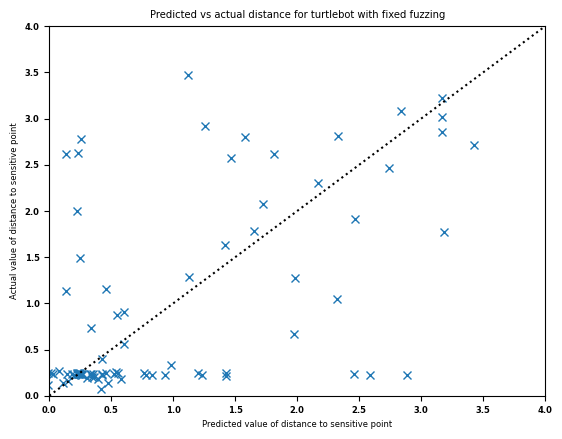

In [91]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.performance_metrics.forecasting import median_absolute_percentage_error

plt.plot(predicted_vs_actual["predicted_val"], predicted_vs_actual["actual_val"],'x')
plt.axline((1,1),(2,2), marker="None", linestyle="dotted", color="Black")
plt.xlabel("Predicted value of distance to sensitive point")
plt.ylabel("Actual value of distance to sensitive point")
plt.xlim([0, 4.0])
plt.ylim([0, 4.0])
plt.title("Predicted vs actual distance for turtlebot with fixed fuzzing");
#mae = MeanAbsoluteError()
mape = median_absolute_percentage_error(predicted_vs_actual["predicted_val"], predicted_vs_actual["actual_val"])
#mae = mae(predicted_vs_actual["predicted_val"], predicted_vs_actual["actual_val"])
mape
plt.savefig("fixedfuzzing_512_twooperations_turtlebot.pdf")

In [92]:
metric_class_count = 4
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)
rocket_cl, predicted_vs_actual = rocket_classifier(base_dir, data_files_train, data_files_test, metrics_train, metrics_test, metric_name, num_kernels, metric_class_count)


Check data:  True
Check data:  True
[0.15749082 0.14346933 1.00408208 2.94381553 0.22806215 0.22831414
 3.01421561 0.23358618 0.22935933 0.22436281 0.24038063 0.25102104
 0.80679933 1.97319664 0.23412839 0.22864355 1.47171317 2.11847535
 0.62415539 0.23595502 0.24154673 0.2363405  0.22993449 0.23239383
 0.0388223  0.23769173 0.61596852 0.23249489 0.02697153 0.96534803
 0.04365061 0.21855372 0.45748453 0.68027561 2.32492612 0.21857284
 0.23580512 0.23242813 1.3372899  0.24113374 0.23144615 0.22646731
 1.55308745 0.23469847 0.22344082 1.02125594 0.10789458 0.25598327
 3.62131189 1.36568888 0.97842165 0.2262487  0.24037121 1.41492459
 0.23039936 0.24026694 0.23807834 0.22387306 0.22802279 3.55675216
 0.22313273 0.06267908 0.77730665 0.21157251 0.78682945 2.89962941
 1.46383579 0.14448205 0.20712126 0.24154987 1.3634341  0.15849206
 0.24205773 0.23675239 2.51881009 0.2249537  0.27820776 3.19262959
 0.24088036 1.35636317 1.84758466 0.13332511 0.26376725 2.8335511
 0.11000688 3.19387155 0.22

Text(0, 0.5, 'Frequency')

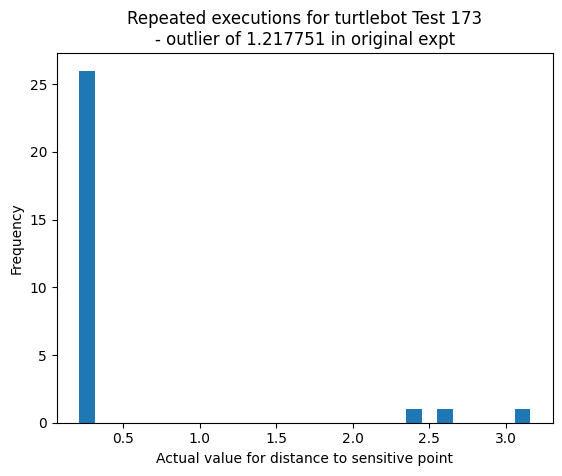

In [5]:
# plot_repeated_runs_of_test_173()
df = pd.read_csv("/home/simtesting/academic/soprano/SPWorkerTemp/notebooks/predictor/temp-data-turtlebot-repeat-173/repeated-res.csv")
plt.hist(df, 29)
plt.title("Repeated executions for turtlebot Test 173\n- outlier of 1.217751 in original expt");
plt.xlabel("Actual value for distance to sensitive point")
plt.ylabel("Frequency")

In [94]:
def plot_cm(norm="all"):
    cm = confusion_matrix(predicted_vs_actual["actual_class"], predicted_vs_actual["predicted_class"], labels=[1,2,3], normalize=norm)
    cmd = ConfusionMatrixDisplay(cm)
    plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})
    cmd.plot()   
    

In [77]:
def compare_prediction_and_actual(classifier, divisor_for_metric_class):
    files_test = sorted(os.listdir(csv_directory_test))
    test_num_max = len(files_test)
    test_data = create_combined_data(csv_directory_test, files_test, needed_columns)
    test_metrics = pd.read_csv(mfile_test)
    actual_class = metrics_map_to_class(test_metrics[metric_name], divisor_for_metric_class)
    actual_val = test_metrics[metric_name]
    predicted_class = classifier.predict(test_data)
    predicted_val = rocket.predict(test_data)
    predicted_vs_actual = pd.DataFrame({'predicted_class':predicted_class, 'actual_class':actual_class, 'predicted_val':predicted_val, 'actual_val':actual_val}, columns = ['predicted_class', 'actual_class', 'predicted_val', 'actual_val'])    
    return predicted_vs_actual

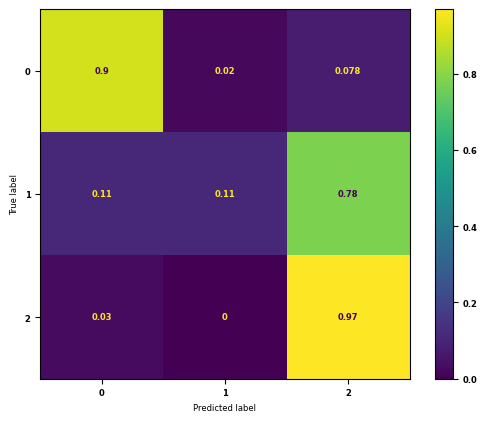

In [22]:
plot_cm(norm="true")

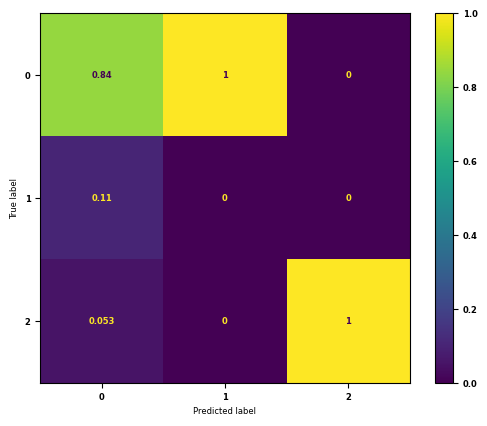

In [331]:
plot_cm(norm="pred")

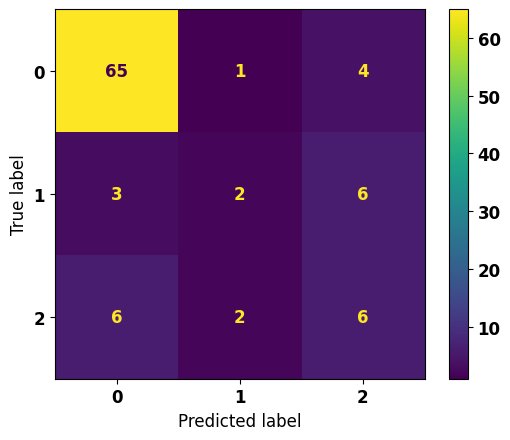

In [95]:
plot_cm(norm=None)

In [96]:
sum(predicted_vs_actual["actual_class"]==1.0)

88

In [95]:
sum(predicted_vs_actual["actual_class"]==1.0) / len(predicted_vs_actual)

0.055415617128463476

In [68]:
0.2 / 0.0554

3.6101083032490977

In [51]:
0.2+0.64+0.12+0.0097+0.029

0.9987000000000001

In [58]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
md = pd.read_csv("/tmp/operationAndMetricLog.csv")
md

,testID,metricValue,rv_start,rv_end,rv_intensity,vel_start,vel_end,vel_intensity
0,Test_001_26_11_2024_03_53_49,1.762991,36.560064,47.330937,0.212117,29.669841,46.400978,0.659818
1,Test_002_26_11_2024_03_53_49,2.922015,33.427812,46.738944,0.515883,45.640690,46.997916,0.544485
2,Test_003_26_11_2024_03_53_49,0.154625,38.247693,41.293853,0.892699,45.062123,47.553375,0.181511
3,Test_004_26_11_2024_03_53_49,0.913575,32.695946,46.212032,0.862032,37.078571,47.787349,0.797909
4,Test_005_26_11_2024_03_53_49,0.236341,32.192160,34.479396,0.236694,37.103515,38.852693,0.137887
5,Test_006_26_11_2024_03_53_49,0.026972,44.653881,45.759877,0.778396,36.275321,39.189332,0.926581
6,Test_007_26_11_2024_03_53_49,1.768129,28.116696,40.209193,0.322163,43.780570,46.075038,0.156790
7,Test_008_26_11_2024_03_53_49,0.457485,29.682578,40.264113,0.941578,25.852432,41.166348,0.855842
8,Test_009_26_11_2024_03_53_49,0.615969,26.406808,32.807220,0.882918,28.891786,43.525360,0.452632
9,Test_010_26_11_2024_03_53_49,0.229249,41.951408,44.608889,0.182062,37.845604,47.178471,0.777765
